[View in Colaboratory](https://colab.research.google.com/github/asonabend/Phenotype_prediction/blob/master/iterative_beta_and_theta.ipynb)

In [0]:

# Code to read csv file into colaboratory:
#!pip install -U -q PyDrive
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.special import expit


In [0]:
!pip install -U -q PyDrive

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2a. Get the file
downloaded = drive.CreateFile({'id':'1fupXX3KJWTbdI7MLPHKbDyEDKAXCzO7a'}) # replace the id with id of file you want to access
downloaded.GetContentFile('raprod2.ra.full.csv')  
#3a. Read file as panda dataframe
dat_pop = pd.read_csv('raprod2.ra.full.csv') 

#2b. Get the file
downloaded = drive.CreateFile({'id':'1Igod8k0utRAqgK4BeEuZqj31JCURQQ5K'}) 
downloaded.GetContentFile('cui2vec_RAsubset.csv')  
#3b. Read file as panda dataframe
cui_subset = pd.read_csv('cui2vec_RAsubset.csv') 

#2c. Get the file
downloaded = drive.CreateFile({'id':'1Z8YK2sVwKeA0OsZQV-sMNeFSkAI0zX02'}) 
downloaded.GetContentFile('C1858558.csv')  
#3c. Read file as panda dataframe
C1858558 = pd.read_csv('C1858558.csv') 


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Clear out old graph
tf.reset_default_graph()

# Create graph
sess = tf.Session()


In [0]:
# Convert to matrix and remove unnamed column:
np_C1858558 = C1858558.loc[:, ~C1858558.columns.str.contains('^Unnamed')].as_matrix()

np_cui_subset = cui_subset.loc[:, ~cui_subset.columns.str.contains('^Unnamed')].as_matrix()

# Select top 10 percent:
# Calculates cosine similarities:
np_cos_sim = ([np_C1858558.dot(np_cui_subset[i,:])/(LA.norm(np_cui_subset[i,:])) for i in range(np_cui_subset.shape[0])]/LA.norm(np_C1858558))
np_cos_sim = np_cos_sim/sum(np_cos_sim)
close_CUIs = (abs(np_cos_sim) > np.percentile(abs(np_cos_sim),0)).flatten()
np_cui_subset = np_cui_subset[close_CUIs,:]

# Create tensorflow constants for RA CUI and the CUI matrix
tf_C1858558 = tf.constant(np_C1858558,name='RAcui', dtype=tf.float32)
tf_cui_subset = tf.constant(np_cui_subset,name='CUIsubset', dtype=tf.float32)

In [0]:
# Calculates cosine similarities:
np_cos_sim = ([np_C1858558.dot(np_cui_subset[i,:])/(LA.norm(np_cui_subset[i,:])) for i in range(np_cui_subset.shape[0])]/LA.norm(np_C1858558))
np_cos_sim = np_cos_sim/sum(np_cos_sim)

# Create tensorflow constants the cosine similarities
tf_cos_sim = tf.constant(np_cos_sim,name='cos_sim', dtype=tf.float32)


In [0]:
# X matrix which contains X_ij, the centered count of CUI j in patient's i notes:
### First I filter the non-labeled rows then I filter the CUI's not mentioned in the notes
counts = dat_pop.loc[dat_pop['label'].isin(['Y','N'])].loc[:,list(cui_subset.iloc[close_CUIs,0])]
### Now I center the counts and convert it to matrix
X = counts.as_matrix().transpose()# Not centered anymore since I use log instead of x^2 (counts-counts.mean()).as_matrix().transpose()
np_X_poly = np.array([[X[cui,:],np.log(X[cui,:]+1),np.sqrt(X[cui,:])] for cui in range(X.shape[0])])#np.array([[np.ones(X.shape[1]),X[cui,:],np.square(X[cui,:])] for cui in range(X.shape[0])])
### Now I convert it to a tensorflow constant:
tf_X_poly = tf.constant(np_X_poly,name='CUIcounts', dtype=tf.float32)#,shape=np_X_poly.shape
# Patients response::
y = dat_pop.loc[dat_pop['label'].isin(['Y','N'])].loc[:,'label'].eq('Y').mul(1).as_matrix()


In [0]:
###
# Model Parameters
###

# Declare batch size
batch_size = 40

# Matrix Dimensions:
CUIs_No, CUIs_dim = np_cui_subset.shape
seed = 116687
patients_No = counts.shape[0]
theta_dim = np_X_poly.shape[1]

In [0]:
# Cosine sim. weighted CUI-embedding matrix:
Vw = tf.multiply(tf_cui_subset,tf_cos_sim)
# Turn it into a 3D tensor for multiplications later:
Vw = tf.expand_dims(Vw, axis=0)
# Replicate the Weighted word-vec matrix for evey patient:
Vws = tf.tile(Vw,[patients_No,1,1])
#Vws = tf.tile(Vw,[batch_size,1,1])

In [0]:
# Initialize parameters 
### theta such that f_j(x_ij)=theta0_j+theta1_j*X_ij+theta2_j*(X_ij)^2:
theta = tf.Variable(tf.random_normal(shape=[CUIs_No,1,theta_dim]),name='theta')
### beta for regression:
beta = tf.Variable(tf.random_normal(shape=[CUIs_dim,1]),name='beta')
beta0 = tf.Variable(tf.random_normal(shape=[1,1]),name='beta0')
# Initialize placeholders
z_data = tf.placeholder(shape=[None, CUIs_dim], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
beta_const = tf.placeholder(shape=[CUIs_dim,1], dtype=tf.float32,name='beta_const')
beta0_const = tf.placeholder(shape=[1,1], dtype=tf.float32,name='beta0_const')


In [0]:
####
# Declare model operations
####
# Calculate f_j(x)=theta0j+theta1j*x_ij+theta2j*x_ij^2 where j is a CUI
f_x = tf.transpose(tf.matmul(theta,tf_X_poly)) # tensor dimensions: (patiens_No,1,CUI_No)
# Cosine sim. weighted CUI-embedding matrix:
# Patient's feature vectors:
tf_z = tf.squeeze(tf.matmul(f_x,Vws))
model_output_beta = tf.sigmoid(tf.add(tf.matmul(z_data, beta), beta0))
model_output_theta = tf.sigmoid(tf.add(tf.matmul(tf_z, beta_const), beta0_const))


In [0]:
###
# Loss Functions
###
### Loss functions to optimize over beta: ###

# Specify 'Ridge' or 'LASSO'
#regression_type = 'LASSO'
regression_type = 'Ridge'

# Select appropriate loss function based on regression type
if regression_type == 'LASSO':

  lasso_param = tf.constant(0.9)
  heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(beta, lasso_param)))))
  regularization_param = tf.multiply(heavyside_step, 99.)
  loss_beta = tf.add(tf.reduce_mean(tf.square(y_target - model_output_beta)), regularization_param)

elif regression_type == 'Ridge':
# Declare the Ridge loss function
# Ridge loss = L2_loss + L2 norm of slope
  ridge_param = tf.constant(1.)
  ridge_loss = tf.reduce_mean(tf.square(beta))
  loss_beta = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output_beta)), tf.multiply(ridge_param, ridge_loss)), 0)
  
### Loss functions to optimize over theta:###
### Do some kind of regularization with theta:
  theta_param = tf.constant(1.)
  theta_reg_loss = tf.reduce_mean(tf.square(theta))
  loss_theta = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output_theta)), tf.multiply(theta_param, theta_reg_loss)), 0)

In [0]:
###
# Optimizer
###

# Declare optimizers
my_opt_beta = tf.train.GradientDescentOptimizer(1e-1)
train_step_beta = my_opt_beta.minimize(loss_beta)

#tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
my_opt_theta = tf.train.GradientDescentOptimizer(1e-1)
train_step_theta = my_opt_theta.minimize(loss_theta)



In [49]:
###
# Run regression
###
# make results reproducible
np.random.seed(seed)
tf.set_random_seed(seed)

# Initialize variables
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init)
np_Z = sess.run(tf_z)
# Training loop
loss_vec = []
for i in range(1500):
    rand_index = np.random.choice(np_Z.shape[0], size=batch_size)
    rand_z = np_Z[rand_index,:]
    rand_y = np.array([y[rand_index]]).transpose()
    sess.run(train_step_beta, feed_dict={z_data: rand_z, y_target: rand_y})
    ##
    np_beta = sess.run(beta)
    np_beta0 = sess.run(beta0)
    y_pred = expit(rand_z.dot(np_beta)+np_beta0)
    sess.run(train_step_theta, feed_dict={beta_const: np_beta, beta0_const: np_beta0, y_target: rand_y})
    rand_z = sess.run(tf_z)
    ##
    temp_loss = sess.run(loss_beta, feed_dict={z_data: rand_z, y_target: rand_y})
    #temp_loss = sess.run(loss_theta, feed_dict={beta_const: np_beta, beta0_const: np_beta0, y_target: rand_y})
    loss_vec.append(temp_loss[0])
    if (i+1)%300==0 or i == 0:
      print('Step #' + str(i+1) + ' beta = ' + str(sess.run(beta)[0]) + ' beta0 = ' + str(sess.run(beta0)) + ' theta = ' + str(sess.run(theta[0,0])))
      print('Loss = ' + str(temp_loss))
      print('AUC = ' + str(metrics.roc_auc_score(rand_y, y_pred)))
      print('\n')


Step #1 beta = [-0.7412476] beta0 = [[0.47241464]] theta = [ 1.2184811 -0.813883   0.0655835]
Loss = [1.1536652]
AUC = 0.34778892181445176


Step #300 beta = [-0.7357184] beta0 = [[-1.1625726]] theta = [ 1.1488328  -0.8022559   0.05272955]
Loss = [0.9051965]
AUC = 0.8599651038442055


Step #600 beta = [-0.6173371] beta0 = [[-1.5854044]] theta = [ 1.1285394  -0.7816573   0.05327776]
Loss = [0.7169861]
AUC = 0.8600986206436996


Step #900 beta = [-0.50676215] beta0 = [[-1.7932833]] theta = [ 1.1069638  -0.7617646   0.05347679]
Loss = [0.6187836]
AUC = 0.9068309816508207


Step #1200 beta = [-0.33377236] beta0 = [[-1.876354]] theta = [ 1.0841409  -0.74256635  0.05333467]
Loss = [0.5105902]
AUC = 0.9485668276972625


Step #1500 beta = [-0.24139516] beta0 = [[-1.9204663]] theta = [ 1.0601759  -0.72420126  0.0526843 ]
Loss = [0.45699298]
AUC = 0.9139433551198257




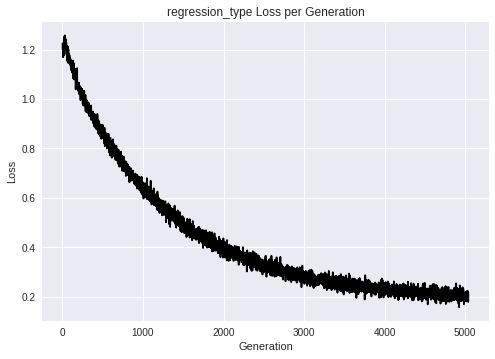

In [48]:
###
# Extract regression results
###

# Plot loss over time
plt.plot(loss_vec, 'k-')#[1000:len(loss_vec)]
plt.title('regression_type' + ' Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()